# Learning Analytics and Model prediction

Goal is to predict the module completion rates using the courses, studentAssessment, and assessments datasets available on Open University Learning Analytics Dataset (OULAD) and investigate which model better predicts based on the model results. 

Data Source: https://www.kaggle.com/rocki37/open-university-learning-analytics-dataset 

Have used Python and SciKitLearn Machine Learning libraries for analyses of data from the OULAD Dataset, which contains data about courses, students and their interactions with Virtual Learning Environment (VLE) for seven selected courses (called modules). 

Github repository# https://github.com/shirleymsassignments/Introduction-to-ML

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy import stats

In [64]:
# Load datasets
courses = pd.read_csv('data/courses.csv')
student_assessments = pd.read_csv('data/studentAssessment.csv')
assessments = pd.read_csv('data/assessments.csv')
student_info = pd.read_csv('data/studentInfo.csv')

# Preview datasets
print("Courses data\n")
print(courses.head())
print("\nStudent_assessments data\n")
print(student_assessments.head())
print("\nAssessments data\n")
print(assessments.head())
print("\nStudent_info data\n")
print(student_info.head())

Courses data

  code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268
3         BBB             2014J                         262
4         BBB             2013B                         240

Student_assessments data

   id_assessment  id_student  date_submitted  is_banked  score
0           1752       11391              18          0   78.0
1           1752       28400              22          0   70.0
2           1752       31604              17          0   72.0
3           1752       32885              26          0   69.0
4           1752       38053              19          0   79.0

Assessments data

  code_module code_presentation  id_assessment assessment_type   date  weight
0         AAA             2013J           1752             TMA   19.0    10.0
1         AAA             2013J           1753

In [26]:
###Merge the datasets based on relevant keys to create a unified dataset for analysis.

In [68]:
# Merge assessments with student assessments on assessment ID
merged_data = pd.merge(student_assessments, assessments, on='id_assessment')

# Merge the result with courses to get course information
merged_data = pd.merge(merged_data, courses, on=['code_module', 'code_presentation'])

merged_data = pd.merge(merged_data, student_info, on=['id_student', 'code_module', 'code_presentation'])

In [69]:
print(merged_data.describe())

       id_assessment    id_student  date_submitted      is_banked  \
count  173912.000000  1.739120e+05   173912.000000  173912.000000   
mean    26553.803556  7.051507e+05      116.032942       0.010977   
std      8829.784254  5.523952e+05       71.484148       0.104194   
min      1752.000000  6.516000e+03      -11.000000       0.000000   
25%     15022.000000  5.044290e+05       51.000000       0.000000   
50%     25359.000000  5.852080e+05      116.000000       0.000000   
75%     34883.000000  6.344980e+05      173.000000       0.000000   
max     37443.000000  2.698588e+06      608.000000       1.000000   

               score           date         weight  \
count  173739.000000  171047.000000  173912.000000   
mean       75.799573     130.605623      12.743899   
std        18.798107      78.025175      17.877301   
min         0.000000      12.000000       0.000000   
25%        65.000000      54.000000       0.000000   
50%        80.000000     129.000000       9.000000   


In [70]:
### Exploratory Data Analysis (EDA)

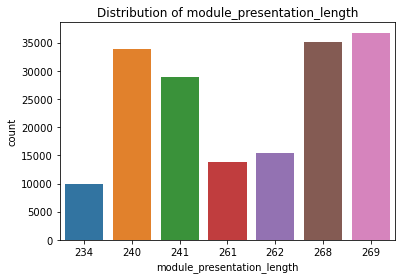

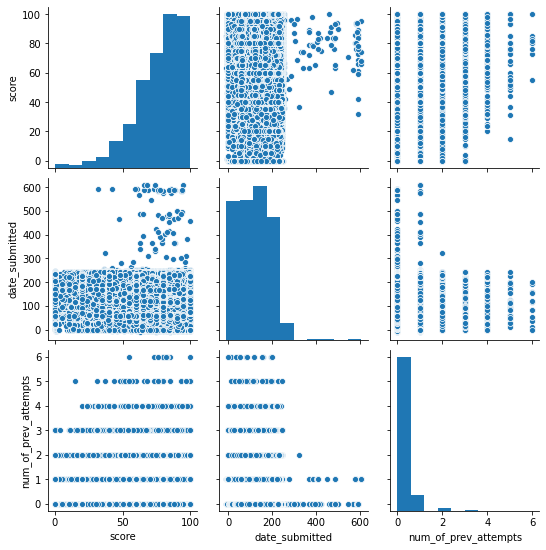

In [74]:
# Distribution of the target variable (e.g., 'final_result')
sns.countplot(merged_data['module_presentation_length'], data=merged_data)
plt.title('Distribution of module_presentation_length')
plt.show()

# Scatter plot for relationships
sns.pairplot(merged_data[['score', 'date_submitted', 'num_of_prev_attempts', 'final_result']])
plt.show()

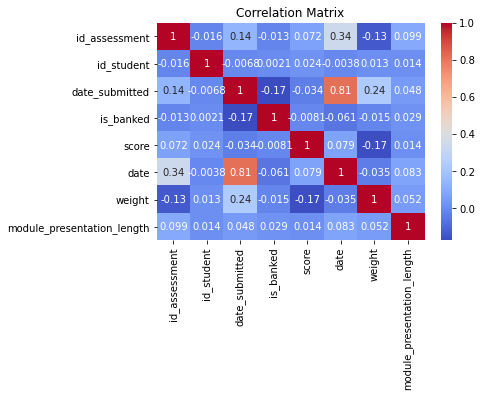

In [52]:
# Correlation matrix
corr_matrix = merged_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The matrix suggests that factors like score, date_submitted, and weight have more substantial impacts on module completion rates

In [53]:
###Data Cleaning

In [75]:
# Check for missing values
print(merged_data.isnull().sum())

# Handle missing values
merged_data = merged_data.dropna()

# Feature Engineering: Create aggregated features
# For example, calculate the total score per course per student
merged_data['total_score'] = merged_data.groupby(['id_student', 'code_module', 'code_presentation'])['score'].transform('sum')

# Drop duplicates or redundant columns if any
merged_data = merged_data.drop_duplicates(subset=['id_student', 'code_module', 'code_presentation'])

id_assessment                    0
id_student                       0
date_submitted                   0
is_banked                        0
score                          173
code_module                      0
code_presentation                0
assessment_type                  0
date                          2865
weight                           0
module_presentation_length       0
gender                           0
region                           0
highest_education                0
imd_band                      7697
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
final_result                     0
dtype: int64


In [82]:
# One-hot encoding for categorical features
categorical_features = ['code_module', 'code_presentation', 'gender', 'region', 'highest_education']
encoded_data = pd.get_dummies(merged_data[categorical_features], drop_first=True)

# Combine with the rest of the data
final_data = pd.concat([merged_data, encoded_data], axis=1)
final_data.drop(categorical_features, axis=1, inplace=True)

In [56]:
## Data preparation

In [83]:
# Select predictors and target variable
X = final_data[['total_score', 'date', 'weight']]  # Select relevant predictors
y = final_data['module_presentation_length']  # Continuous target: length of the module presentation

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (if necessary)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
## Model Building: Linear Regression

In [98]:
# LinearRegression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test) # prediction

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Coefficients interpretation
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Model Evaluation
print("\n\n\nLogistic Regression:\n\n")
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr)}')
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Mean Squared Error: 168.54732316882414
R-squared: 0.020088379419650915
             Coefficient
total_score    -1.394672
date            0.808240
weight          1.014224



Logistic Regression:


Accuracy: 0.4300100704934542
[[244   0   0   0   0   0   0]
 [  0 278  52   0  77 252  55]
 [  0   0 156  29  79 161 434]
 [  0   0 176  32   0   0 240]
 [  0 103   3   0 504   0   3]
 [  0 292   1   2  93 431 181]
 [  0   0 154  29  99 315 490]]
              precision    recall  f1-score   support

         234       1.00      1.00      1.00       244
         240       0.41      0.39      0.40       714
         241       0.29      0.18      0.22       859
         261       0.35      0.07      0.12       448
         262       0.59      0.82      0.69       613
         268       0.37      0.43      0.40      1000
         269       0.35      0.45      0.39      1087

    accuracy                           0.43      4965
   macro avg       0.48      0.48      0.46      4965
weighted avg  

In [99]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n\n\nRandom Forest:\n\n")
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf)}')
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))




Random Forest:


Accuracy: 0.611681772406848
[[244   0   0   0   0   0   0]
 [  0 408   0   1   0 304   1]
 [  0   1 306 167   0  33 352]
 [  0   0 135 278   0   0  35]
 [  0   0   0   0 612   0   1]
 [  0 289  27   0   0 563 121]
 [  0   0 289  69   0 103 626]]
              precision    recall  f1-score   support

         234       1.00      1.00      1.00       244
         240       0.58      0.57      0.58       714
         241       0.40      0.36      0.38       859
         261       0.54      0.62      0.58       448
         262       1.00      1.00      1.00       613
         268       0.56      0.56      0.56      1000
         269       0.55      0.58      0.56      1087

    accuracy                           0.61      4965
   macro avg       0.66      0.67      0.67      4965
weighted avg       0.61      0.61      0.61      4965



In [97]:
### Residual Analysis

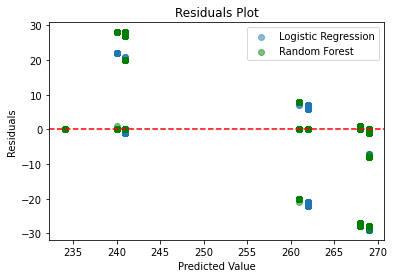

In [96]:
# Residuals for Logistic Regression
residuals_lr = y_test - y_pred_lr

# Residuals for Random Forest
residuals_rf = y_test - y_pred_rf

# Plot Residuals
plt.figure()
plt.scatter(y_pred_lr, residuals_lr, alpha=0.5, label='Logistic Regression')
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5, color='green', label='Random Forest')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()
plt.show()

# Analysis

# Linear Regression 

MSE indicates the average squared difference between predicted and actual values. A higher MSE suggests that the model's predictions are not close to the actual values.
R-squared is very low (0.020), meaning the model explains only 2% of the variance in the target variable. This suggests that the linear regression model is not suitable for this data.

# Logistic Regression
Accuracy is 0.43, which is quite low and suggests that the model performs poorly in predicting module completion.

Precision and Recall vary significantly across classes, with high precision and recall for some classes (ex: Class 234) and very low for others (Ex: Class 261)

# Random Forest
Accuracy is 0.61, indicating that the Random Forest model performs better than Logistic Regression.
Precision and Recall are more balanced across classes compared to Logistic Regression.

# Visualizing Model Performance

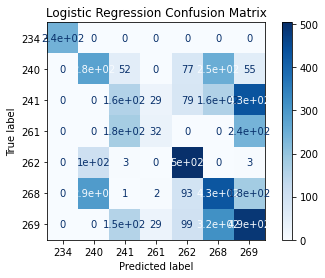

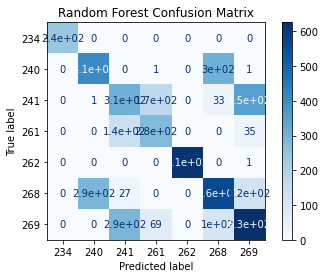

In [101]:
from sklearn.metrics import ConfusionMatrixDisplay

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['234', '240', '241', '261', '262', '268', '269'])
disp_lr.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['234', '240', '241', '261', '262', '268', '269'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()


# Summary and Conclusion

Based on the model results, it concludes that the Logistic Regression model shows better performance than Linear Regression with an accuracy of 0.43. However, it struggles with class imbalance, and its precision/recall are inconsistent across classes. The Random Forest model has the highest accuracy (0.61) and provides more balanced precision and recall across different classes compared to Logistic Regression. 

Random Forest is the best-performing model among the three for predicting module completion rates. It achieves the highest accuracy and shows more balanced performance across different classes.